# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [1]:
%matplotlib notebook
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from helpers.plot import plotter
import matplotlib.dates as mdates

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [2]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    # def alpha(t):
    #     return s * I/N + alpha_opt
    dSdt = - beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [3]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    if -k*(-t+x0) >= 500: return R_0_end
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

We can find the numerical solution to the ODEs 

In [4]:
def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    # infection rate comes from current R0
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    # model bed usage in the poplation
    def beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    # run model
    N = sum(agegroups)
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D, delta

Next, define the hyper-parameter rates of the model

In [5]:
gamma = 1.0 / 9.0 # 9 days from infection to recovery
delta = 1.0 / 2.0  # incubation period of two days
epsilon = 1.0 / 7.0 # a week for latent person to recover
theta = 1.0 / 3.0 # three days for latent to show symptoms
lamda = 1.0 / 5.0 # five days for infected to be critical
tau = 1.0 / 6.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

Finally, running the model and plotting the numerical solution over time. 

percentage going to ICU: 60.0; percentage dying in ICU: 50.0


<IPython.core.display.Javascript object>


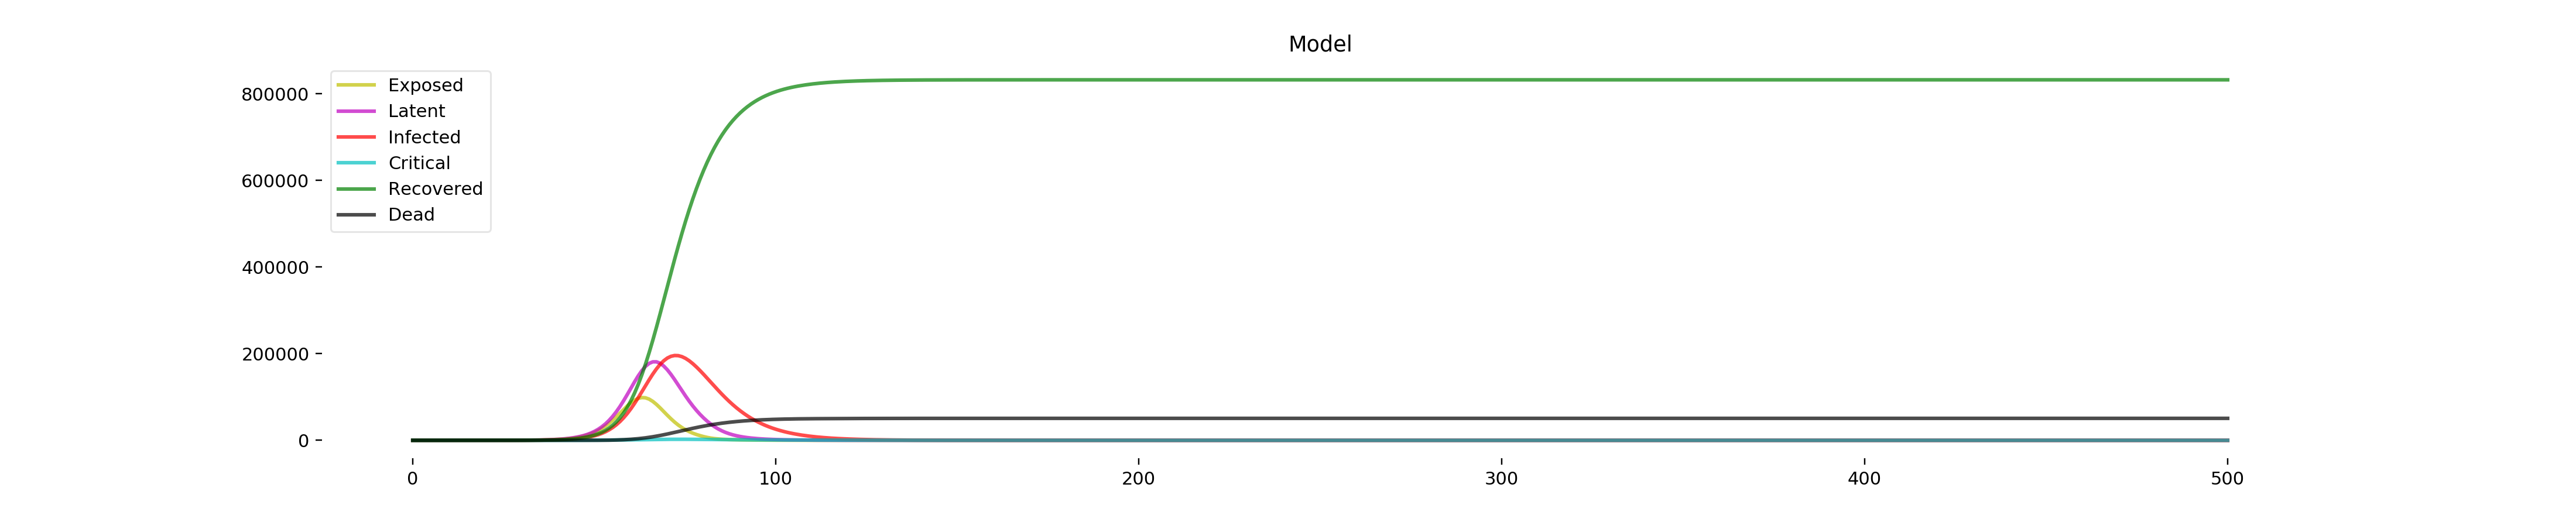

<IPython.core.display.Javascript object>


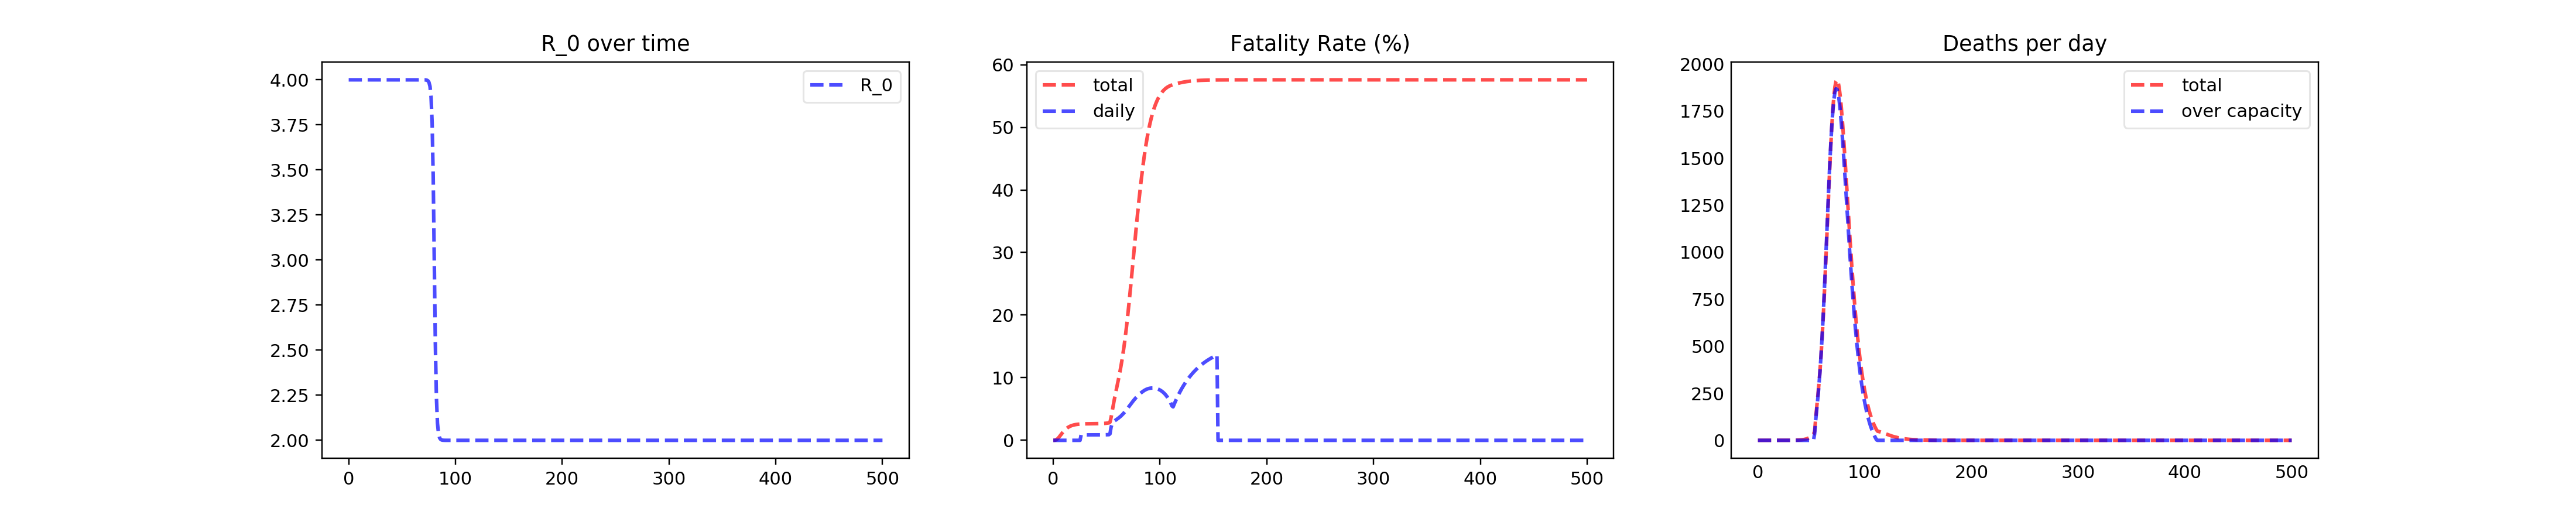

In [6]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=80, R_0_end=2.0, p_L_to_R=0.5,
               p_I_to_C=0.05, p_C_to_D=0.6, s=0.003))

In [7]:
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]
covid_data["Location"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [8]:
beds["Country"].unique()

array(['Japan', 'South Korea', 'Russia', 'Germany', 'Austria', 'Hungary',
       'Czech Republic', 'Poland', 'Lithuania', 'France', 'Slovakia',
       'Belgium', 'Latvia', 'Hong Kong', 'Estonia', 'Luxembourg',
       'Switzerland', 'Slovenia', 'China', 'Greece', 'Australia',
       'Norway', 'Portugal', 'Netherlands', 'Finland', 'Italy', 'Iceland',
       'Israel', 'Spain', 'Ireland', 'Turkey', 'United States',
       'New Zealand', 'Denmark', 'United Kingdom', 'Canada', 'Sweden',
       'Chile', 'Colombia', 'India', 'Mexico', 'Africa', 'Europe', 'Asia',
       'North America', 'South America'], dtype=object)

In [9]:
agegroups['Location'].unique()

array(['World', 'Sustainable Development Goal (SDG) regions',
       'Sub-Saharan Africa', 'Eastern Africa', 'Burundi', 'Comoros',
       'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi',
       'Mauritius', 'Mayotte', 'Mozambique', 'Réunion', 'Rwanda',
       'Seychelles', 'Somalia', 'South Sudan', 'Uganda', 'Tanzania',
       'Zambia', 'Zimbabwe', 'Middle Africa', 'Angola', 'Cameroon',
       'Central African Republic', 'Chad', 'Congo',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Sao Tome and Principe', 'Southern Africa', 'Botswana', 'Eswatini',
       'Lesotho', 'Namibia', 'South Africa', 'Western Africa', 'Benin',
       'Burkina Faso', 'Cabo Verde', "Cote d'Ivoire", 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania',
       'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo',
       'Northern Africa and Western Asia', 'Northern Africa', 'Algeria',
       'Egypt', 'Libya', 'Morocco', 'Sudan',

In [10]:
country = "US"
# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
beds_lookup["US"] = beds_lookup["United States"]
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))
# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [11]:
# parameters
data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
agegroups = agegroup_lookup[country]
beds_per_100k = beds_lookup[country]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 1.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (96, 30, 100), "R_0_end": (0.9, 0.3, 3.5), "p_L_to_R": (0.6, 0.4, 0.8),
                       "p_I_to_C": (0.05, 0.01, 0.1), "p_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

## Parameter Fitting

In [12]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
    return ret[6][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

<IPython.core.display.Javascript object>


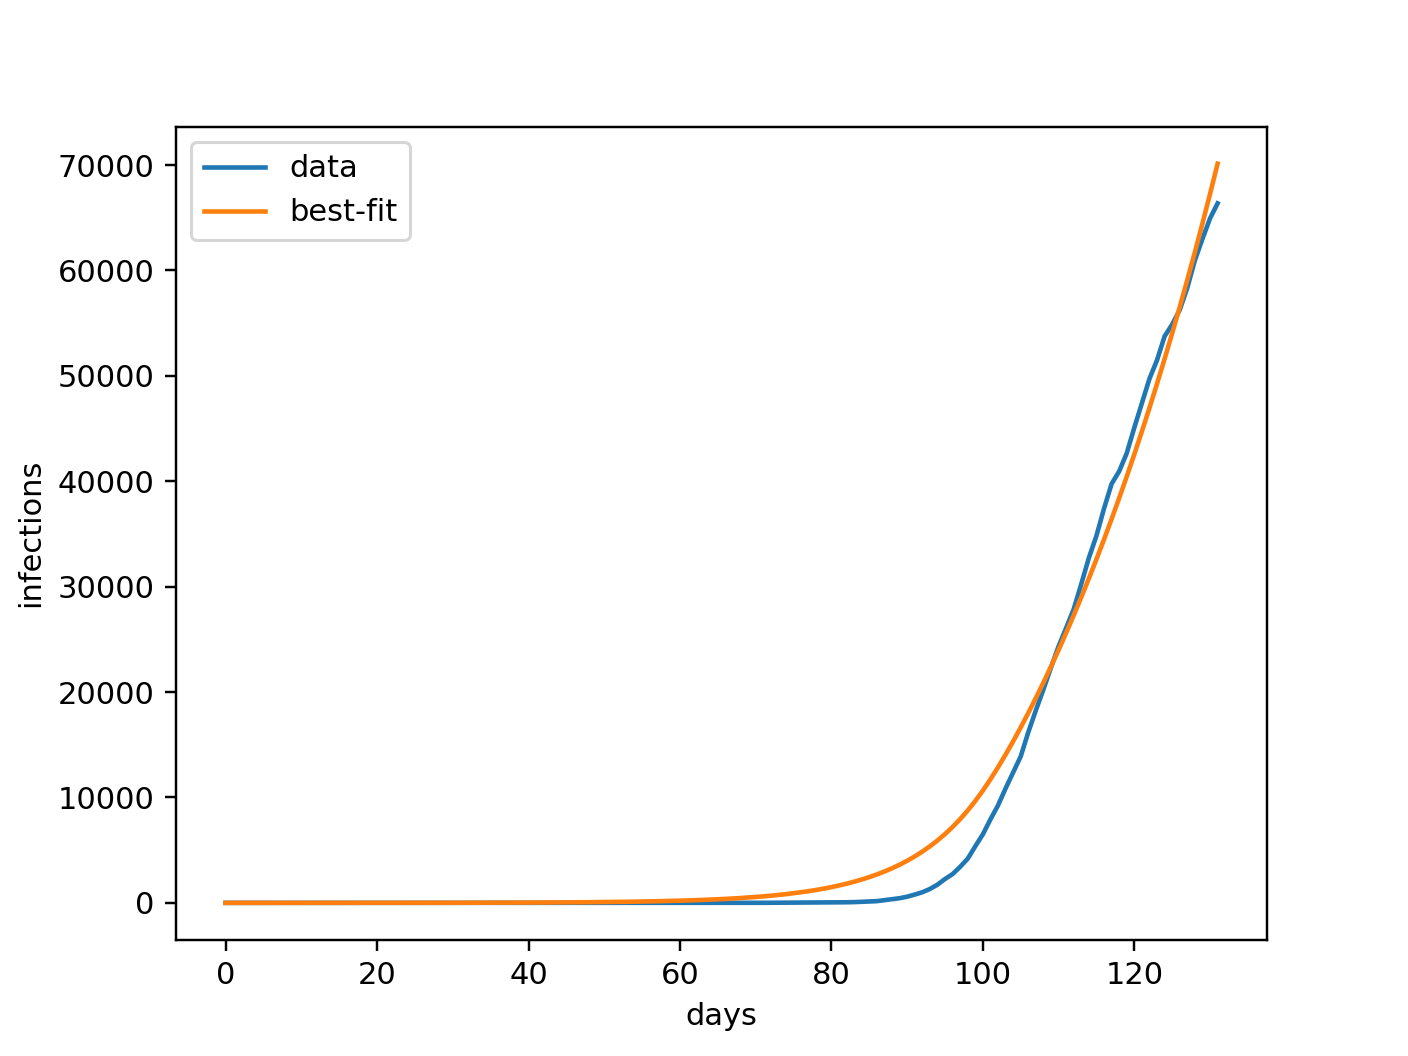

{'R_0_start': 1.986949468836978, 'k': 1.5437696930501217, 'x0': 99.9999999999994, 'R_0_end': 1.1507508589886406, 'p_L_to_R': 0.4000000000000001, 'p_I_to_C': 0.09999999997346522, 'p_C_to_D': 0.05000001519605392, 's': 0.003}


In [13]:
params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)
ax = plt.subplots()
result.plot_fit(datafmt="-");
plt.xlabel('days')
plt.ylabel('infections')
plt.title('')
plt.show()
print(result.best_values)

Prediction for US
percentage going to ICU: 5.000001519605392; percentage dying in ICU: 50.0


<IPython.core.display.Javascript object>


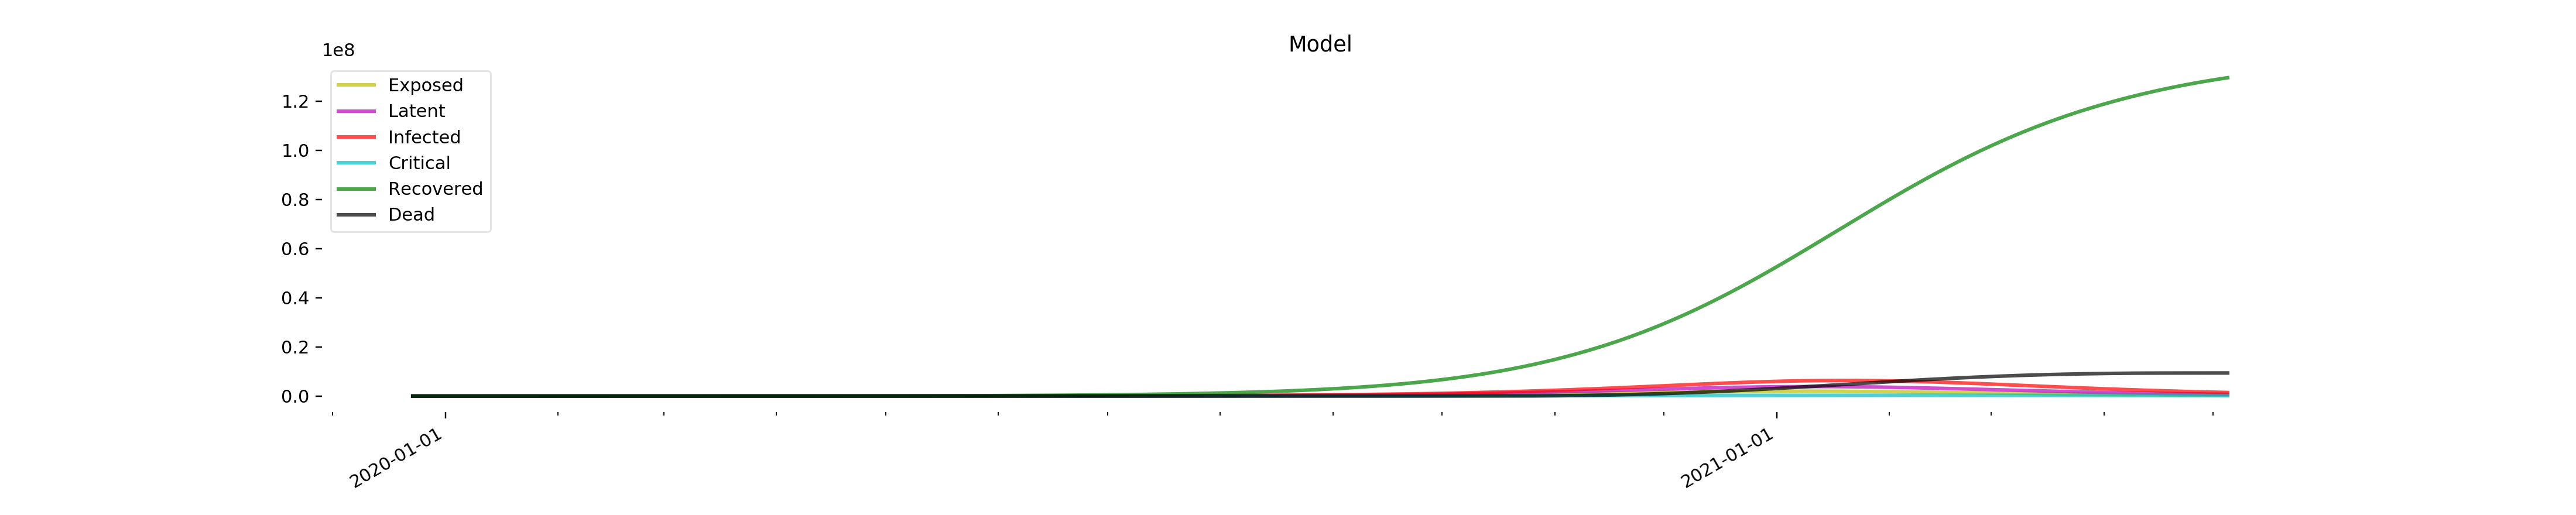

<IPython.core.display.Javascript object>


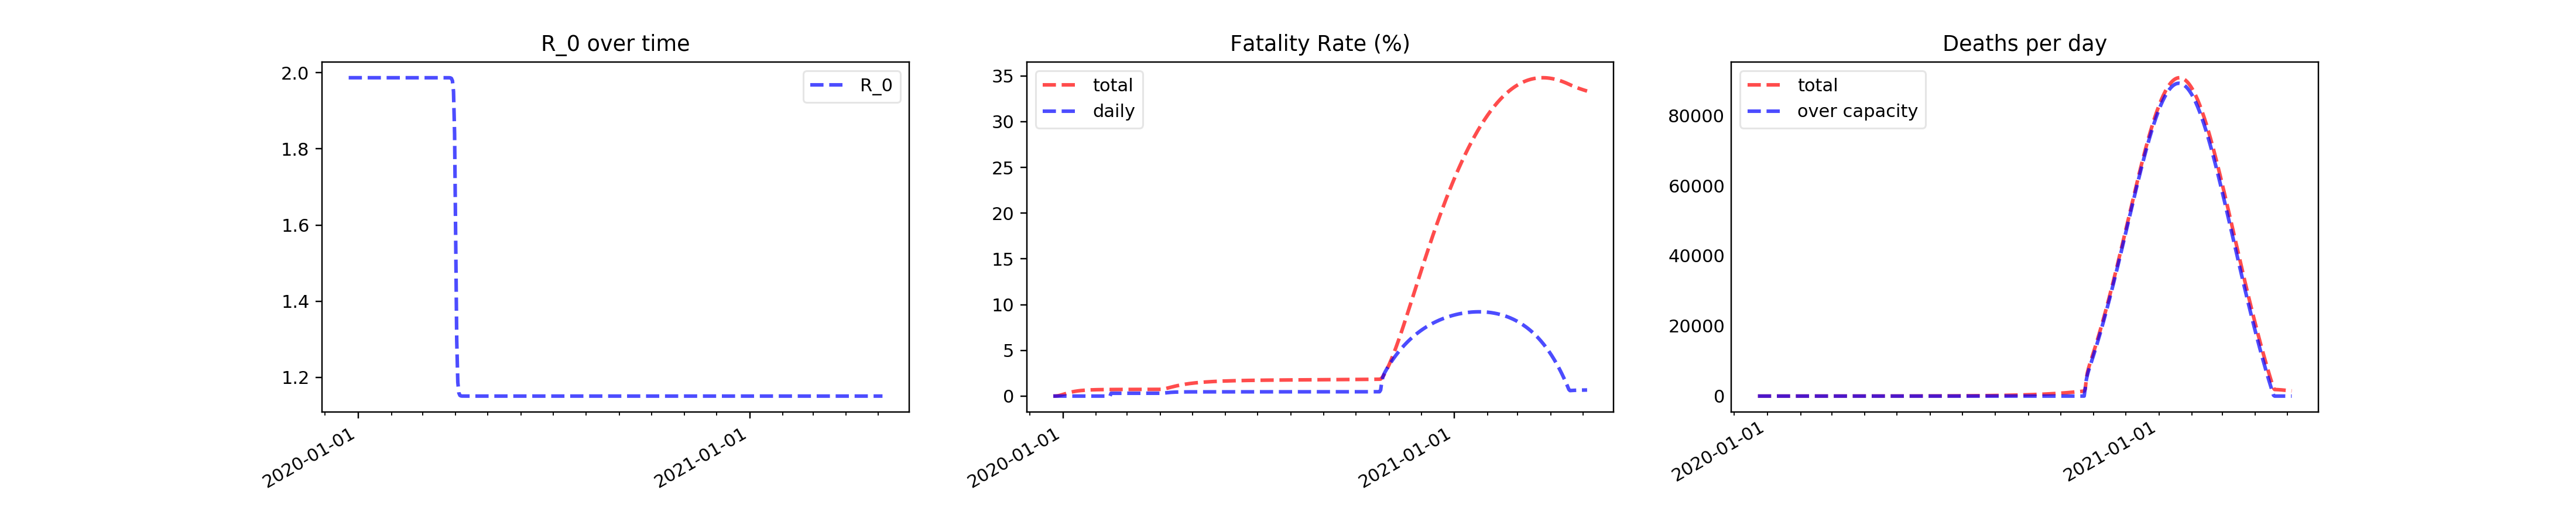

In [14]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for " + country)
plotter(*Model(full_days, agegroup_lookup[country], beds_lookup[country], **result.best_values), x_ticks=x_ticks);